<a href="https://colab.research.google.com/github/yohoobot/works/blob/main/experiment_yes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install evaluate bert_score rouge_score nltk --quiet


  Preparing metadata (setup.py) ... done


In [ ]:
# 10
# 80+Ê†∑Êú¨ÔºåÂ∏¶Ê≠åÂêçÊú™Ê∏ÖÊ¥ó
# musicgen_scene_music_pairs_train.jsonl
# musicgen_scene_music_pairs_test.jsonl
# few-shot k=2
# 1 epoch

# ‚úÖ ÂÆâË£Ö‰∏ÄÊ¨°Âç≥ÂèØ
# !pip install evaluate bert_score rouge_score nltk --quiet
# !pip install git+https://github.com/google-research/bleurt.git

# ‚úÖ ÂØºÂÖ•ÊâÄÈúÄÊ®°Âùó
import json
import random
import requests
from tqdm import tqdm
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ‚úÖ ËØªÂèñÊï∞ÊçÆ
with open("musicgen_scene_music_pairs_train.jsonl", "r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]
with open("musicgen_scene_music_pairs_test.jsonl", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]

# ‚úÖ ËÆæÁΩÆ API
QWEN_API_KEY = "sk-"
QWEN_API_URL = "https://dashscope.aliyuncs.com/api/v1/services/aigc/text-generation/generation"

# ‚úÖ ÊûÑÂª∫ few-shot prompt
def build_few_shot_messages(k=2):
    examples = random.sample(train_data, k)
    messages = [{"role": "system", "content": "You are a music cognition expert converting restaurant scene descriptions into music prompts suitable for MusicGen."}]
    for ex in examples:
        messages.append({"role": "user", "content": f"Scene: {ex['scene']}"})
        messages.append({"role": "assistant", "content": ex['music']})
    return messages

# ‚úÖ Ë∞ÉÁî® Qwen API
def generate_music_description(scene_desc):
    messages = build_few_shot_messages()
    messages.append({"role": "user", "content": f"Scene: {scene_desc}"})
    headers = {
        "Authorization": f"Bearer {QWEN_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "qwen2.5-14b-instruct",
        "input": {"messages": messages},
        "parameters": {"temperature": 0.5, "max_tokens": 150}
    }
    response = requests.post(QWEN_API_URL, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json().get("output", {}).get("text", "").strip()
    else:
        return "ERROR"

# ‚úÖ ÈÅçÂéÜÊµãËØïÈõÜÂÅöÊé®ÁêÜ
generated = []
for item in tqdm(test_data):
    scene = item["scene"]
    reference = item["music"]
    prediction = generate_music_description(scene)
    generated.append({"scene": scene, "reference": reference, "prediction": prediction})

# ‚úÖ ÊèêÂèñÁî®‰∫éËØÑ‰º∞ÁöÑÊñáÊú¨
references = [x["reference"] for x in generated]
predictions = [x["prediction"] for x in generated]

# ‚úÖ ËØÑ‰º∞ÔºöBLEUÔºà‰ΩøÁî® NLTKÔºâ
smoothie = SmoothingFunction().method4
bleu_scores = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie) for ref, pred in zip(references, predictions)]
avg_bleu = sum(bleu_scores) / len(bleu_scores)

# ‚úÖ ËØÑ‰º∞ÔºöROUGE / METEOR / BERTScore / BLEURT
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")
bleurt = evaluate.load("bleurt", module_type="metric", checkpoint="bleurt-base-128")

rouge_result = rouge.compute(predictions=predictions, references=references)
meteor_result = meteor.compute(predictions=predictions, references=references)
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
bleurt_result = bleurt.compute(predictions=predictions, references=references)

# ‚úÖ ËæìÂá∫ËØÑ‰º∞ÁªìÊûú
print("üéØ Evaluation Results:")
print(f"BLEU: {avg_bleu:.4f}")
print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")
print(f"METEOR: {meteor_result['meteor']:.4f}")
print(f"BERTScore (F1): {sum(bertscore_result['f1'])/len(bertscore_result['f1']):.4f}")
print(f"BLEURT: {sum(bleurt_result['scores'])/len(bleurt_result['scores']):.4f}")


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 37/37 [02:17<00:00,  3.72s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


üéØ Evaluation Results:
BLEU: 0.0107
ROUGE-L: 0.0860
METEOR: 0.0741
BERTScore (F1): 0.7378
BLEURT: -1.2052


In [ ]:
# 21 32
# 80+Ê†∑Êú¨ÔºåÂ∑≤ÁªèÊõøÊç¢‰∏∫ this is aÔºåÂ∑≤Ê∏ÖÊ¥ó
# musicgen_scene_music_pairs_train_v2.jsonl
# musicgen_scene_music_pairs_test_v2.jsonl
# few-shot k=4
# 1 epoch

# ‚úÖ ÂÆâË£Ö‰æùËµñÔºàÈ¶ñÊ¨°ËøêË°åÔºâ
# !pip install evaluate bert_score rouge_score nltk --quiet
# !pip install git+https://github.com/google-research/bleurt.git

# ‚úÖ ÂØºÂÖ•Ê®°Âùó
import json
import random
import requests
from tqdm import tqdm
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ‚úÖ ËØªÂèñÊñ∞Êï∞ÊçÆÈõÜÔºàÂ∑≤ÁªèÊõøÊç¢‰∫Ü is a ‰∏∫ this is aÔºâ
with open("musicgen_scene_music_pairs_train_v2.jsonl", "r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]
with open("musicgen_scene_music_pairs_test_v2.jsonl", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]

# ‚úÖ Qwen API ËÆæÁΩÆÔºàËØ∑ÊõøÊç¢‰∏∫‰Ω†Ëá™Â∑±ÁöÑ API KeyÔºâ
QWEN_API_KEY = "sk-"
QWEN_API_URL = "https://dashscope.aliyuncs.com/api/v1/services/aigc/text-generation/generation"

# ‚úÖ ÊûÑÈÄ† few-shot prompt
def build_few_shot_messages(k=2):
    examples = random.sample(train_data, k)
    messages = [{
        "role": "system",
        "content": "You are a music cognition expert. Convert restaurant scene descriptions into MusicGen-style music prompts. Describe BPM, genre, mood, key, instrumentation."
    }]
    for ex in examples:
        messages.append({"role": "user", "content": f"Scene: {ex['scene']}"})
        messages.append({"role": "assistant", "content": ex['music']})
    return messages

# ‚úÖ Ë∞ÉÁî® Qwen Êé•Âè£
def generate_music_description(scene_desc):
    messages = build_few_shot_messages(k=2)
    messages.append({"role": "user", "content": f"Scene: {scene_desc}"})
    headers = {
        "Authorization": f"Bearer {QWEN_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "qwen2.5-14b-instruct",
        "input": {"messages": messages},
        "parameters": {"temperature": 0.5, "max_tokens": 150}
    }
    response = requests.post(QWEN_API_URL, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json().get("output", {}).get("text", "").strip()
    else:
        return "ERROR"

# ‚úÖ ÈÅçÂéÜÊµãËØïÈõÜÁîüÊàêÈ¢ÑÊµã
results = []
for sample in tqdm(test_data):
    pred = generate_music_description(sample["scene"])
    results.append({
        "scene": sample["scene"],
        "reference": sample["music"],
        "prediction": pred
    })

# ‚úÖ ‰øùÂ≠òÁîüÊàêÁªìÊûú
output_path = "/content/qwen_fewshot_outputs_v2.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

# ‚úÖ ËØÑ‰º∞ÈÉ®ÂàÜ
references = [x["reference"] for x in results]
predictions = [x["prediction"] for x in results]

rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

smoothie = SmoothingFunction().method4
bleu_scores = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie) for ref, pred in zip(references, predictions)]
avg_bleu = sum(bleu_scores) / len(bleu_scores)
rouge_result = rouge.compute(predictions=predictions, references=references)
meteor_result = meteor.compute(predictions=predictions, references=references)
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
avg_bertscore_f1 = sum(bertscore_result["f1"]) / len(bertscore_result["f1"])

# ‚úÖ ËæìÂá∫ËØÑ‰º∞ÁªìÊûú
print("\nüéØ Evaluation Results (Qwen Few-shot ‚Üí Music Description):")
print(f"BLEU: {avg_bleu:.4f}")
print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")
print(f"METEOR: {meteor_result['meteor']:.4f}")
print(f"BERTScore (F1): {avg_bertscore_f1:.4f}")


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:09<00:00,  3.66s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üéØ Evaluation Results (Qwen Few-shot ‚Üí Music Description):
BLEU: 0.0237
ROUGE-L: 0.1313
METEOR: 0.1477
BERTScore (F1): 0.7770


In [ ]:
# 40
# 185Ê†∑Êú¨ÔºåÊú™Ê∏ÖÊ¥ó
# musicgen_scene_music_pairs_all_train.jsonl
# musicgen_scene_music_pairs_all_test.jsonl
# few-shot k=4
# 1 epoch

# ‚úÖ ÂÆâË£Ö‰æùËµñÔºàÈ¶ñÊ¨°ËøêË°åÔºâ
# !pip install evaluate bert_score rouge_score nltk --quiet
# !pip install git+https://github.com/google-research/bleurt.git

# ‚úÖ ÂØºÂÖ•Ê®°Âùó
import json
import random
import requests
from tqdm import tqdm
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ‚úÖ ËØªÂèñÊñ∞Êï∞ÊçÆÈõÜÔºà185Êù°ÂÆåÊï¥Êï∞ÊçÆÔºåÊ†ºÂºèÂ∑≤Ê†áÂáÜÂåñÔºâ
with open("musicgen_scene_music_pairs_all_train.jsonl", "r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]
with open("musicgen_scene_music_pairs_all_test.jsonl", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]

# ‚úÖ Qwen API ËÆæÁΩÆÔºàËØ∑ÊõøÊç¢‰∏∫‰Ω†Ëá™Â∑±ÁöÑ API KeyÔºâ
QWEN_API_KEY = "sk-"
QWEN_API_URL = "https://dashscope.aliyuncs.com/api/v1/services/aigc/text-generation/generation"

# ‚úÖ ÊûÑÈÄ† few-shot promptÔºà‰ΩøÁî® 4 Êù°Ôºâ
def build_few_shot_messages(k=4):
    examples = random.sample(train_data, k)
    messages = [{
        "role": "system",
        "content": "You are a music cognition expert. Convert restaurant scene descriptions into MusicGen-style music prompts. Describe BPM, genre, mood, key, instrumentation."
    }]
    for ex in examples:
        messages.append({"role": "user", "content": f"Scene: {ex['scene']}"})
        messages.append({"role": "assistant", "content": ex['music']})
    return messages

# ‚úÖ Ë∞ÉÁî® Qwen Êé•Âè£
def generate_music_description(scene_desc):
    messages = build_few_shot_messages(k=4)
    messages.append({"role": "user", "content": f"Scene: {scene_desc}"})
    headers = {
        "Authorization": f"Bearer {QWEN_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "qwen2.5-14b-instruct",
        "input": {"messages": messages},
        "parameters": {"temperature": 0.5, "max_tokens": 150}
    }
    response = requests.post(QWEN_API_URL, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json().get("output", {}).get("text", "").strip()
    else:
        return "ERROR"

# ‚úÖ ÈÅçÂéÜÊµãËØïÈõÜÁîüÊàêÈ¢ÑÊµã
results = []
for sample in tqdm(test_data):
    pred = generate_music_description(sample["scene"])
    results.append({
        "scene": sample["scene"],
        "reference": sample["music"],
        "prediction": pred
    })

# ‚úÖ ‰øùÂ≠òÁîüÊàêÁªìÊûú
output_path = "/content/qwen_fewshot_outputs_full.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

# ‚úÖ ËØÑ‰º∞ÈÉ®ÂàÜ
references = [x["reference"] for x in results]
predictions = [x["prediction"] for x in results]

rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

smoothie = SmoothingFunction().method4
bleu_scores = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie) for ref, pred in zip(references, predictions)]
avg_bleu = sum(bleu_scores) / len(bleu_scores)
rouge_result = rouge.compute(predictions=predictions, references=references)
meteor_result = meteor.compute(predictions=predictions, references=references)
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
avg_bertscore_f1 = sum(bertscore_result["f1"]) / len(bertscore_result["f1"])

# ‚úÖ ËæìÂá∫ËØÑ‰º∞ÁªìÊûú
print("\nüéØ Evaluation Results (Qwen Few-shot ‚Üí Music Description):")
print(f"BLEU: {avg_bleu:.4f}")
print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")
print(f"METEOR: {meteor_result['meteor']:.4f}")
print(f"BERTScore (F1): {avg_bertscore_f1:.4f}")


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:20<00:00,  4.23s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üéØ Evaluation Results (Qwen Few-shot ‚Üí Music Description):
BLEU: 0.0368
ROUGE-L: 0.1669
METEOR: 0.1989
BERTScore (F1): 0.7900


In [ ]:
# 50
# 185Ê†∑Êú¨ÔºåÂ∑≤Ê∏ÖÊ¥ó
# musicgen_scene_music_pairs_all_cleaned_train.jsonl
# musicgen_scene_music_pairs_all_cleaned_test.jsonl
# few-shot k=4
# 1 epoch


# ‚úÖ ÂÆâË£Ö‰æùËµñÔºàÈ¶ñÊ¨°ËøêË°åÔºâ
# !pip install evaluate bert_score rouge_score nltk --quiet
# !pip install git+https://github.com/google-research/bleurt.git

# ‚úÖ ÂØºÂÖ•Ê®°Âùó
import json
import random
import requests
from tqdm import tqdm
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ‚úÖ ËØªÂèñÊñ∞Êï∞ÊçÆÈõÜÔºà185Êù°ÂÆåÊï¥Êï∞ÊçÆÔºåÊ†ºÂºèÂ∑≤Ê†áÂáÜÂåñÔºâ
with open("musicgen_scene_music_pairs_all_cleaned_train.jsonl", "r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]
with open("musicgen_scene_music_pairs_all_cleaned_test.jsonl", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]

# ‚úÖ Qwen API ËÆæÁΩÆÔºàËØ∑ÊõøÊç¢‰∏∫‰Ω†Ëá™Â∑±ÁöÑ API KeyÔºâ
QWEN_API_KEY = "sk-"
QWEN_API_URL = "https://dashscope.aliyuncs.com/api/v1/services/aigc/text-generation/generation"

# ‚úÖ ÊûÑÈÄ† few-shot promptÔºà‰ΩøÁî® 4 Êù°Ôºâ
def build_few_shot_messages(k=4):
    examples = random.sample(train_data, k)
    messages = [{
        "role": "system",
        "content": "You are a music cognition expert. Convert restaurant scene descriptions into MusicGen-style music prompts. Describe BPM, genre, mood, key, instrumentation."
    }]
    for ex in examples:
        messages.append({"role": "user", "content": f"Scene: {ex['scene']}"})
        messages.append({"role": "assistant", "content": ex['music']})
    return messages

# ‚úÖ Ë∞ÉÁî® Qwen Êé•Âè£
def generate_music_description(scene_desc):
    messages = build_few_shot_messages(k=4)
    messages.append({"role": "user", "content": f"Scene: {scene_desc}"})
    headers = {
        "Authorization": f"Bearer {QWEN_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "qwen2.5-14b-instruct",
        "input": {"messages": messages},
        "parameters": {"temperature": 0.5, "max_tokens": 150}
    }
    response = requests.post(QWEN_API_URL, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json().get("output", {}).get("text", "").strip()
    else:
        return "ERROR"

# ‚úÖ ÈÅçÂéÜÊµãËØïÈõÜÁîüÊàêÈ¢ÑÊµã
results = []
for sample in tqdm(test_data):
    pred = generate_music_description(sample["scene"])
    results.append({
        "scene": sample["scene"],
        "reference": sample["music"],
        "prediction": pred
    })

# ‚úÖ ‰øùÂ≠òÁîüÊàêÁªìÊûú
output_path = "/content/qwen_fewshot_outputs_full.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

# ‚úÖ ËØÑ‰º∞ÈÉ®ÂàÜ
references = [x["reference"] for x in results]
predictions = [x["prediction"] for x in results]

rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

smoothie = SmoothingFunction().method4
bleu_scores = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie) for ref, pred in zip(references, predictions)]
avg_bleu = sum(bleu_scores) / len(bleu_scores)
rouge_result = rouge.compute(predictions=predictions, references=references)
meteor_result = meteor.compute(predictions=predictions, references=references)
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
avg_bertscore_f1 = sum(bertscore_result["f1"]) / len(bertscore_result["f1"])

# ‚úÖ ËæìÂá∫ËØÑ‰º∞ÁªìÊûú
print("\nüéØ Evaluation Results (Qwen Few-shot ‚Üí Music Description):")
print(f"BLEU: {avg_bleu:.4f}")
print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")
print(f"METEOR: {meteor_result['meteor']:.4f}")
print(f"BERTScore (F1): {avg_bertscore_f1:.4f}")


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:27<00:00,  4.59s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üéØ Evaluation Results (Qwen Few-shot ‚Üí Music Description):
BLEU: 0.0194
ROUGE-L: 0.1438
METEOR: 0.1679
BERTScore (F1): 0.7902



üöÄ Round 1/5


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:22<00:00,  4.32s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 2/5


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:19<00:00,  4.20s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 3/5


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:21<00:00,  4.28s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 4/5


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:19<00:00,  4.16s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 5/5


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:21<00:00,  4.29s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


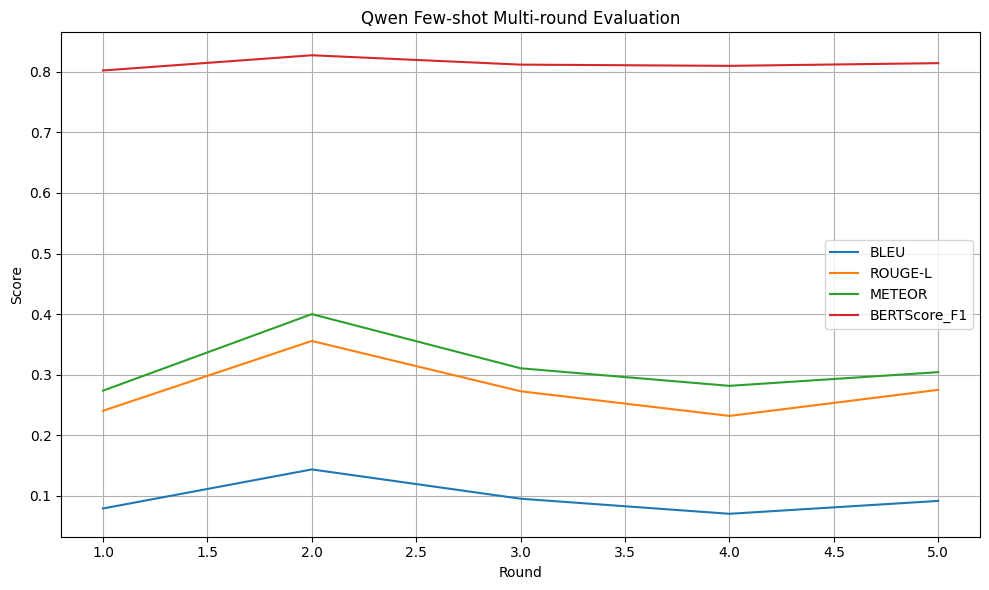


üìä Round 1 Scores:
BLEU: 0.0792
ROUGE-L: 0.2405
METEOR: 0.2737
BERTScore_F1: 0.8022

üìä Round 2 Scores:
BLEU: 0.1437
ROUGE-L: 0.3557
METEOR: 0.4000
BERTScore_F1: 0.8273

üìä Round 3 Scores:
BLEU: 0.0953
ROUGE-L: 0.2727
METEOR: 0.3106
BERTScore_F1: 0.8118

üìä Round 4 Scores:
BLEU: 0.0704
ROUGE-L: 0.2320
METEOR: 0.2816
BERTScore_F1: 0.8098

üìä Round 5 Scores:
BLEU: 0.0917
ROUGE-L: 0.2750
METEOR: 0.3042
BERTScore_F1: 0.8142


In [ ]:
# 63
# 185Ê†∑Êú¨ÔºåÂ∑≤Ê∏ÖÊ¥ó
# musicgen_scene_music_pairs_all_cleaned_train.jsonl
# musicgen_scene_music_pairs_all_cleaned_test.jsonl
# few-shot k=6
# 5 epoch

# ‚úÖ ÂÆâË£Ö‰æùËµñÔºàÈ¶ñÊ¨°ËøêË°åÔºâ
# !pip install evaluate bert_score rouge_score nltk --quiet
# !pip install git+https://github.com/google-research/bleurt.git

# ‚úÖ ÂØºÂÖ•Ê®°Âùó
import json
import random
import requests
from tqdm import tqdm
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

# ‚úÖ ËØªÂèñÊñ∞Êï∞ÊçÆÈõÜÔºà185Êù°ÂÆåÊï¥Êï∞ÊçÆÔºåÊ†ºÂºèÂ∑≤Ê†áÂáÜÂåñÔºâ
with open("musicgen_scene_music_pairs_all_cleaned_train.jsonl", "r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]
with open("musicgen_scene_music_pairs_all_cleaned_test.jsonl", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]

# ‚úÖ Qwen API ËÆæÁΩÆÔºàËØ∑ÊõøÊç¢‰∏∫‰Ω†Ëá™Â∑±ÁöÑ API KeyÔºâ
QWEN_API_KEY = "sk-"
QWEN_API_URL = "https://dashscope.aliyuncs.com/api/v1/services/aigc/text-generation/generation"

# ‚úÖ ÊûÑÈÄ† few-shot promptÔºàÊØèËΩÆ 6 Êù°Ôºâ
def build_few_shot_messages(k=6):
    examples = random.sample(train_data, k)
    messages = [{
        "role": "system",
        "content": "You are a music cognition expert. Convert restaurant scene descriptions into MusicGen-style music prompts. Describe BPM, genre, mood, key, instrumentation."
    }]
    for ex in examples:
        messages.append({"role": "user", "content": f"Scene: {ex['scene']}"})
        messages.append({"role": "assistant", "content": ex['music']})
    return messages

# ‚úÖ Ë∞ÉÁî® Qwen Êé•Âè£
def generate_music_description(scene_desc, k=6):
    messages = build_few_shot_messages(k)
    messages.append({"role": "user", "content": f"Scene: {scene_desc}"})
    headers = {
        "Authorization": f"Bearer {QWEN_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "qwen2.5-14b-instruct",
        "input": {"messages": messages},
        "parameters": {"temperature": 0.5, "max_tokens": 150}
    }
    response = requests.post(QWEN_API_URL, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json().get("output", {}).get("text", "").strip()
    else:
        return "ERROR"

# ‚úÖ Â§öËΩÆÈ™åËØÅÔºàÈªòËÆ§ 5 ËΩÆÔºâ
epochs = 5
results_by_round = []

for round_idx in range(epochs):
    print(f"\nüöÄ Round {round_idx + 1}/{epochs}")
    round_results = []
    for sample in tqdm(test_data):
        pred = generate_music_description(sample["scene"], k=6)
        round_results.append({
            "scene": sample["scene"],
            "reference": sample["music"],
            "prediction": pred
        })

    references = [x["reference"] for x in round_results]
    predictions = [x["prediction"] for x in round_results]

    rouge = evaluate.load("rouge")
    meteor = evaluate.load("meteor")
    bertscore = evaluate.load("bertscore")

    smoothie = SmoothingFunction().method4
    bleu_scores = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie) for ref, pred in zip(references, predictions)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    rouge_result = rouge.compute(predictions=predictions, references=references)
    meteor_result = meteor.compute(predictions=predictions, references=references)
    bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
    avg_bertscore_f1 = sum(bertscore_result["f1"]) / len(bertscore_result["f1"])

    results_by_round.append({
        "BLEU": avg_bleu,
        "ROUGE-L": rouge_result["rougeL"],
        "METEOR": meteor_result["meteor"],
        "BERTScore_F1": avg_bertscore_f1
    })

# ‚úÖ ÂèØËßÜÂåñËØÑ‰º∞ÊåáÊ†á
rounds = list(range(1, epochs + 1))
plt.figure(figsize=(10, 6))
for metric in ["BLEU", "ROUGE-L", "METEOR", "BERTScore_F1"]:
    scores = [res[metric] for res in results_by_round]
    plt.plot(rounds, scores, label=metric)

plt.xlabel("Round")
plt.ylabel("Score")
plt.title("Qwen Few-shot Multi-round Evaluation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ‚úÖ ËæìÂá∫ÊØèËΩÆÂæóÂàÜË°®Ê†º
for idx, scores in enumerate(results_by_round):
    print(f"\nüìä Round {idx + 1} Scores:")
    for k, v in scores.items():
        print(f"{k}: {v:.4f}")


üöÄ Round 1/5


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:24<00:00,  4.46s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 2/5


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:32<00:00,  4.85s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 3/5


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:31<00:00,  4.82s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 4/5


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:27<00:00,  4.62s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 5/5


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:32<00:00,  4.88s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


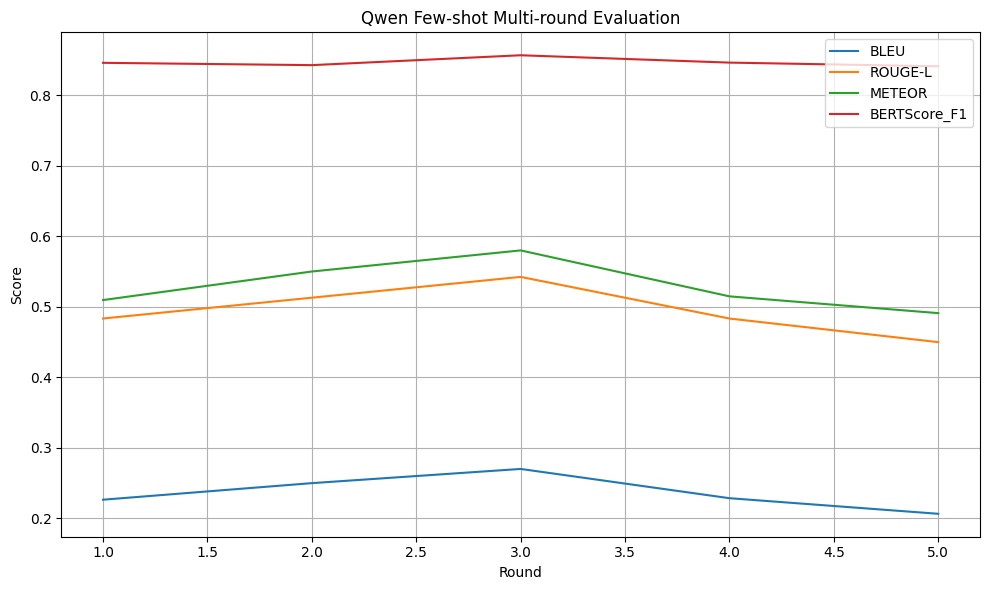


üìä Round 1 Scores:
BLEU: 0.2262
ROUGE-L: 0.4832
METEOR: 0.5094
BERTScore_F1: 0.8459

üìä Round 2 Scores:
BLEU: 0.2497
ROUGE-L: 0.5127
METEOR: 0.5499
BERTScore_F1: 0.8426

üìä Round 3 Scores:
BLEU: 0.2698
ROUGE-L: 0.5422
METEOR: 0.5798
BERTScore_F1: 0.8566

üìä Round 4 Scores:
BLEU: 0.2283
ROUGE-L: 0.4831
METEOR: 0.5146
BERTScore_F1: 0.8462

üìä Round 5 Scores:
BLEU: 0.2062
ROUGE-L: 0.4497
METEOR: 0.4908
BERTScore_F1: 0.8410


In [ ]:
# 74
# 185Ê†∑Êú¨ÔºåÂ∑≤Ê∏ÖÊ¥ó
# musicgen_scene_music_pairs_all_cleaned_train.jsonl
# musicgen_scene_music_pairs_all_cleaned_test.jsonl
# few-shot k=10
# 5 epoch

# ‚úÖ ÂÆâË£Ö‰æùËµñÔºàÈ¶ñÊ¨°ËøêË°åÔºâ
# !pip install evaluate bert_score rouge_score nltk --quiet
# !pip install git+https://github.com/google-research/bleurt.git

# ‚úÖ ÂØºÂÖ•Ê®°Âùó
import json
import random
import requests
from tqdm import tqdm
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

# ‚úÖ ËØªÂèñÊñ∞Êï∞ÊçÆÈõÜÔºà185Êù°ÂÆåÊï¥Êï∞ÊçÆÔºåÊ†ºÂºèÂ∑≤Ê†áÂáÜÂåñÔºâ
with open("musicgen_scene_music_pairs_all_cleaned_train.jsonl", "r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]
with open("musicgen_scene_music_pairs_all_cleaned_test.jsonl", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]

# ‚úÖ Qwen API ËÆæÁΩÆÔºàËØ∑ÊõøÊç¢‰∏∫‰Ω†Ëá™Â∑±ÁöÑ API KeyÔºâ
QWEN_API_KEY = "sk-"
QWEN_API_URL = "https://dashscope.aliyuncs.com/api/v1/services/aigc/text-generation/generation"

# ‚úÖ ÊûÑÈÄ† few-shot promptÔºàÊØèËΩÆ 10 Êù°Ôºâ
def build_few_shot_messages(k=10):
    examples = random.sample(train_data, k)
    messages = [{
        "role": "system",
        "content": "You are a music cognition expert. Convert restaurant scene descriptions into MusicGen-style music prompts. Describe BPM, genre, mood, key, instrumentation."
    }]
    for ex in examples:
        messages.append({"role": "user", "content": f"Scene: {ex['scene']}"})
        messages.append({"role": "assistant", "content": ex['music']})
    return messages

# ‚úÖ Ë∞ÉÁî® Qwen Êé•Âè£
def generate_music_description(scene_desc, k=10):
    messages = build_few_shot_messages(k)
    messages.append({"role": "user", "content": f"Scene: {scene_desc}"})
    headers = {
        "Authorization": f"Bearer {QWEN_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "qwen2.5-14b-instruct",
        "input": {"messages": messages},
        "parameters": {"temperature": 0.5, "max_tokens": 150}
    }
    response = requests.post(QWEN_API_URL, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json().get("output", {}).get("text", "").strip()
    else:
        return "ERROR"

# ‚úÖ Â§öËΩÆÈ™åËØÅÔºàÈªòËÆ§ 5 ËΩÆÔºâ
epochs = 5
results_by_round = []

for round_idx in range(epochs):
    print(f"\nüöÄ Round {round_idx + 1}/{epochs}")
    round_results = []
    for sample in tqdm(test_data):
        pred = generate_music_description(sample["scene"], k=10)
        round_results.append({
            "scene": sample["scene"],
            "reference": sample["music"],
            "prediction": pred
        })

    references = [x["reference"] for x in round_results]
    predictions = [x["prediction"] for x in round_results]

    rouge = evaluate.load("rouge")
    meteor = evaluate.load("meteor")
    bertscore = evaluate.load("bertscore")

    smoothie = SmoothingFunction().method4
    bleu_scores = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie) for ref, pred in zip(references, predictions)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    rouge_result = rouge.compute(predictions=predictions, references=references)
    meteor_result = meteor.compute(predictions=predictions, references=references)
    bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
    avg_bertscore_f1 = sum(bertscore_result["f1"]) / len(bertscore_result["f1"])

    results_by_round.append({
        "BLEU": avg_bleu,
        "ROUGE-L": rouge_result["rougeL"],
        "METEOR": meteor_result["meteor"],
        "BERTScore_F1": avg_bertscore_f1
    })

# ‚úÖ ÂèØËßÜÂåñËØÑ‰º∞ÊåáÊ†á
rounds = list(range(1, epochs + 1))
plt.figure(figsize=(10, 6))
for metric in ["BLEU", "ROUGE-L", "METEOR", "BERTScore_F1"]:
    scores = [res[metric] for res in results_by_round]
    plt.plot(rounds, scores, label=metric)

plt.xlabel("Round")
plt.ylabel("Score")
plt.title("Qwen Few-shot Multi-round Evaluation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ‚úÖ ËæìÂá∫ÊØèËΩÆÂæóÂàÜË°®Ê†º
for idx, scores in enumerate(results_by_round):
    print(f"\nüìä Round {idx + 1} Scores:")
    for k, v in scores.items():
        print(f"{k}: {v:.4f}")


üöÄ Round 1/10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:30<00:00,  4.74s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 2/10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:30<00:00,  4.74s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 3/10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:32<00:00,  4.85s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 4/10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:33<00:00,  4.92s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 5/10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:43<00:00,  5.42s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 6/10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:28<00:00,  4.64s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 7/10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:29<00:00,  4.69s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 8/10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:26<00:00,  4.55s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 9/10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:26<00:00,  4.55s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



üöÄ Round 10/10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [01:32<00:00,  4.85s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


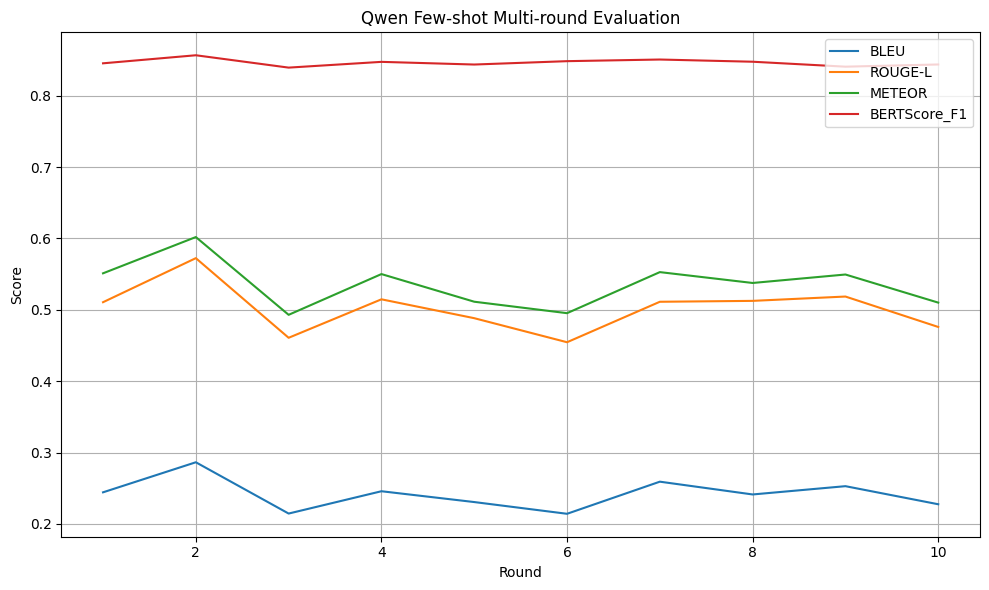


üìä Round 1 Scores:
BLEU: 0.2442
ROUGE-L: 0.5106
METEOR: 0.5511
BERTScore_F1: 0.8453

üìä Round 2 Scores:
BLEU: 0.2863
ROUGE-L: 0.5723
METEOR: 0.6019
BERTScore_F1: 0.8566

üìä Round 3 Scores:
BLEU: 0.2145
ROUGE-L: 0.4607
METEOR: 0.4929
BERTScore_F1: 0.8393

üìä Round 4 Scores:
BLEU: 0.2457
ROUGE-L: 0.5146
METEOR: 0.5500
BERTScore_F1: 0.8473

üìä Round 5 Scores:
BLEU: 0.2306
ROUGE-L: 0.4882
METEOR: 0.5113
BERTScore_F1: 0.8436

üìä Round 6 Scores:
BLEU: 0.2141
ROUGE-L: 0.4545
METEOR: 0.4952
BERTScore_F1: 0.8483

üìä Round 7 Scores:
BLEU: 0.2591
ROUGE-L: 0.5112
METEOR: 0.5528
BERTScore_F1: 0.8506

üìä Round 8 Scores:
BLEU: 0.2412
ROUGE-L: 0.5125
METEOR: 0.5375
BERTScore_F1: 0.8475

üìä Round 9 Scores:
BLEU: 0.2528
ROUGE-L: 0.5185
METEOR: 0.5494
BERTScore_F1: 0.8406

üìä Round 10 Scores:
BLEU: 0.2275
ROUGE-L: 0.4759
METEOR: 0.5100
BERTScore_F1: 0.8437


In [ ]:
# 85
# 185Ê†∑Êú¨ÔºåÂ∑≤Ê∏ÖÊ¥ó
# musicgen_scene_music_pairs_all_cleaned_train.jsonl
# musicgen_scene_music_pairs_all_cleaned_test.jsonl
# few-shot k=10
# 10 epoch

# ‚úÖ ÂÆâË£Ö‰æùËµñÔºàÈ¶ñÊ¨°ËøêË°åÔºâ
# !pip install evaluate bert_score rouge_score nltk --quiet
# !pip install git+https://github.com/google-research/bleurt.git

# ‚úÖ ÂØºÂÖ•Ê®°Âùó
import json
import random
import requests
from tqdm import tqdm
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

# ‚úÖ ËØªÂèñÊñ∞Êï∞ÊçÆÈõÜÔºà185Êù°ÂÆåÊï¥Êï∞ÊçÆÔºåÊ†ºÂºèÂ∑≤Ê†áÂáÜÂåñÔºâ
with open("musicgen_scene_music_pairs_all_cleaned_train.jsonl", "r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]
with open("musicgen_scene_music_pairs_all_cleaned_test.jsonl", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]

# ‚úÖ Qwen API ËÆæÁΩÆÔºàËØ∑ÊõøÊç¢‰∏∫‰Ω†Ëá™Â∑±ÁöÑ API KeyÔºâ
QWEN_API_KEY = "sk-"
QWEN_API_URL = "https://dashscope.aliyuncs.com/api/v1/services/aigc/text-generation/generation"

# ‚úÖ ÊûÑÈÄ† few-shot promptÔºàÊØèËΩÆ 10 Êù°Ôºâ
def build_few_shot_messages(k=10):
    examples = random.sample(train_data, k)
    messages = [{
        "role": "system",
        "content": "You are a music cognition expert. Convert restaurant scene descriptions into MusicGen-style music prompts. Describe BPM, genre, mood, key, instrumentation."
    }]
    for ex in examples:
        messages.append({"role": "user", "content": f"Scene: {ex['scene']}"})
        messages.append({"role": "assistant", "content": ex['music']})
    return messages

# ‚úÖ Ë∞ÉÁî® Qwen Êé•Âè£
def generate_music_description(scene_desc, k=10):
    messages = build_few_shot_messages(k)
    messages.append({"role": "user", "content": f"Scene: {scene_desc}"})
    headers = {
        "Authorization": f"Bearer {QWEN_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "qwen2.5-14b-instruct",
        "input": {"messages": messages},
        "parameters": {"temperature": 0.5, "max_tokens": 150}
    }
    response = requests.post(QWEN_API_URL, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json().get("output", {}).get("text", "").strip()
    else:
        return "ERROR"

# ‚úÖ Â§öËΩÆÈ™åËØÅÔºàÈªòËÆ§ 5 ËΩÆÔºâ
epochs = 10
results_by_round = []

for round_idx in range(epochs):
    print(f"\nüöÄ Round {round_idx + 1}/{epochs}")
    round_results = []
    for sample in tqdm(test_data):
        pred = generate_music_description(sample["scene"], k=10)
        round_results.append({
            "scene": sample["scene"],
            "reference": sample["music"],
            "prediction": pred
        })

    references = [x["reference"] for x in round_results]
    predictions = [x["prediction"] for x in round_results]

    rouge = evaluate.load("rouge")
    meteor = evaluate.load("meteor")
    bertscore = evaluate.load("bertscore")

    smoothie = SmoothingFunction().method4
    bleu_scores = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie) for ref, pred in zip(references, predictions)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    rouge_result = rouge.compute(predictions=predictions, references=references)
    meteor_result = meteor.compute(predictions=predictions, references=references)
    bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
    avg_bertscore_f1 = sum(bertscore_result["f1"]) / len(bertscore_result["f1"])

    results_by_round.append({
        "BLEU": avg_bleu,
        "ROUGE-L": rouge_result["rougeL"],
        "METEOR": meteor_result["meteor"],
        "BERTScore_F1": avg_bertscore_f1
    })

# ‚úÖ ÂèØËßÜÂåñËØÑ‰º∞ÊåáÊ†á
rounds = list(range(1, epochs + 1))
plt.figure(figsize=(10, 6))
for metric in ["BLEU", "ROUGE-L", "METEOR", "BERTScore_F1"]:
    scores = [res[metric] for res in results_by_round]
    plt.plot(rounds, scores, label=metric)

plt.xlabel("Round")
plt.ylabel("Score")
plt.title("Qwen Few-shot Multi-round Evaluation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ‚úÖ ËæìÂá∫ÊØèËΩÆÂæóÂàÜË°®Ê†º
for idx, scores in enumerate(results_by_round):
    print(f"\nüìä Round {idx + 1} Scores:")
    for k, v in scores.items():
        print(f"{k}: {v:.4f}")